## Import Packages

In [1]:
import datetime
import random
import numpy as np
from numpy.fft import fft, fftfreq
import scipy.stats as stats
from scipy.linalg import logm, expm
import matplotlib.pyplot as plt

## Fourier series

Assuming a signal $y(t)$ with length $T$ that we want to analyze its power spectrum, we can decompose $y$ by Fourier series

$$
y = \sum_{k=0}^{N} a_k cos(\frac{k \pi t}{T}) + b_k sin(\frac{k \pi t}{T})
$$


By using ```np.fft.fft```, we can get the Fourier coefficients $c_k$ corresponding to frequency $k$. The explained variance by one specific frequency $k$ can be computed by

$$
Exp Var = \frac{2 \cdot c_k \cdot c_k^*}{T^2}
$$

where $c_k^2 = a_k^2 + b_k^2$

## RMM index

We start from the power spectrum of Realtime Multivariate MJO index (RMM index), which is a useful tool to monitor the strength and phase of MJO.

To meet the demand of statistical robustness, we separate the RMM index into several chunks. Because we want to retain some interannual variability, a five-year chunk size is selected here.

In [2]:
# Read rmm data
rmm1, rmm2 = np.loadtxt("./rmm.79to21.txt", unpack = True, skiprows = 2, usecols = (3, 4))
rmm1 -= rmm1.mean(); rmm1 /= rmm1.std()
rmm2 -= rmm2.mean(); rmm2 /= rmm2.std()

In [3]:
# Separate into chunks
chunk_size = 5 # years
chunk_list = []
for yr in range(1979, 2021-chunk_size+1):
    julian_day1 = (datetime.datetime(yr, 1, 1) - datetime.datetime(1979, 1, 1)).days
    julian_day2 = (datetime.datetime(yr + chunk_size, 1, 1) - datetime.datetime(1979, 1, 1)).days
    chunk_list.append([julian_day1, julian_day2])

In [4]:
len(chunk_list)

38

In [5]:
# Calculate power spectrum
def calc_power_spectrum(signal, chunk_size = 5):
    size = np.floor(chunk_size * 365 / 2).astype(int)
    ck   = fft(signal)
    freq = fftfreq(len(signal))
    sp   = 2 * ck * ck.conj() / len(signal)**2
    return freq[:size], sp[:size]

In [6]:
sp_rmm1_list = np.zeros((len(chunk_list), np.floor(chunk_size * 365 / 2).astype(int)))
sp_rmm2_list = np.zeros((len(chunk_list), np.floor(chunk_size * 365 / 2).astype(int)))

for i, chunk in enumerate(chunk_list):
    freq_rmm1, sp_rmm1 = calc_power_spectrum(rmm1[chunk[0]:chunk[1]], chunk_size = chunk_size)
    freq_rmm2, sp_rmm2 = calc_power_spectrum(rmm2[chunk[0]:chunk[1]], chunk_size = chunk_size)
    sp_rmm1_list[i] = sp_rmm1 / sp_rmm1.sum() # retaining the total variance in 1
    sp_rmm2_list[i] = sp_rmm2 / sp_rmm2.sum() # retaining the total variance in 1

/tmp/ipykernel_1166486/2906366704.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  sp_rmm1_list[i] = sp_rmm1 / sp_rmm1.sum() # retaining the total variance in 1
/tmp/ipykernel_1166486/2906366704.py:8: ComplexWarning: Casting complex values to real discards the imaginary part
  sp_rmm2_list[i] = sp_rmm2 / sp_rmm2.sum() # retaining the total variance in 1


Text(0.5, 1.0, 'Power spectrum of RMM2')

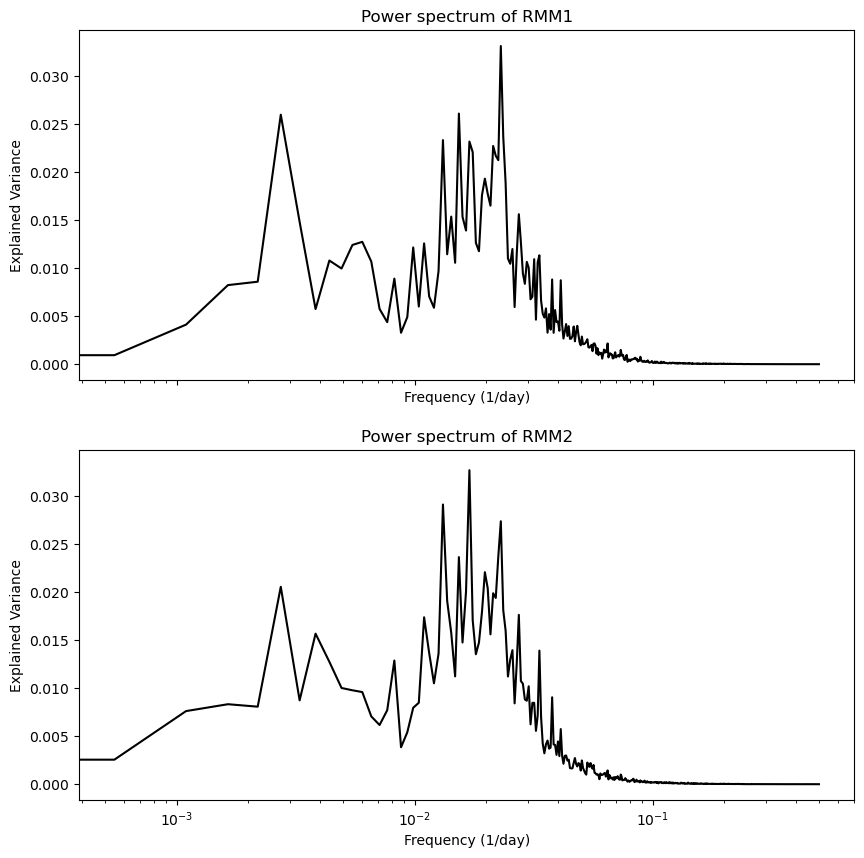

In [7]:
f, ax = plt.subplots(2, 1, figsize = (10, 10), sharex = True, sharey = True)
ax[0].plot(freq_rmm1, sp_rmm1_list.mean(axis = 0), color = "k", label = "RMM1")
ax[1].plot(freq_rmm2, sp_rmm2_list.mean(axis = 0), color = "k", label = "RMM2")
ax[0].set_xscale("log")
ax[1].set_xscale("log")
ax[0].set_xlabel("Frequency (1/day)")
ax[1].set_xlabel("Frequency (1/day)")
ax[0].set_ylabel("Explained Variance")
ax[1].set_ylabel("Explained Variance")
ax[0].set_title("Power spectrum of RMM1")
ax[1].set_title("Power spectrum of RMM2")

## Red noise

A red noise process has the form

$$
X_{t + \tau} = aX_{t} + \epsilon
$$

where $a$ is the memory of the system, and $\epsilon$ is a random forcing.

By Gilman et al. 1963, an ideal, infinite-length lag-1 red noise has a power spetrum of

$$
Sp(k) = \frac{1 - a^2}{1 + a^2 - 2\ a\ cos(2k \pi)}
$$

where $k$ is the frequency.

## RMM index vs Red noise

Our goal is to tell the difference between RMM index and red noise. However, it is impossible for us to obtain an infinite-length RMM index. And comparing the finite-length data with infinite-length red noise could be problematic as well.

So we have to generate a set of red noise having the same length as our RMM index does. The memory coefficient can be easily computed from an auto-regression

$$
a = X_{t+\tau}^T X_{t} \ /  \ X_{t}^T X_{t}
$$

The forcing is randomly selected from a normal distribution

$$
\epsilon \in N(\mu = 0,\ \ \sigma = \sqrt{1 - a^2})
$$

We integrate the red noise system for a long period (~1000 years). Following the concept of previous section, we select 38 five-year chunks from the long-term red noise and compute their average power spectrum. By repeating this procedure for several times, we can get the mean and confidence interval of the red noise power spectrum.

In [8]:
# lead-lag regression coefficient
def calc_a(signal, lag = 1):
    x0 = signal[:-lag]
    x1 = signal[lag:]
    x0 = np.reshape(x0, (1, len(x0)))
    x1 = np.reshape(x1, (1, len(x1)))
    c0 = np.matmul(x0, x0.T)
    ct = np.matmul(x1, x0.T)
    a  = np.matmul(ct, np.linalg.inv(c0))
    a  = np.squeeze(expm(logm(a) / lag)) # take the lag-th root to get the regression coefficient at lag 1
    return a

In [9]:
# red noise model
def time_integral(x: float, a: float, e: float):
    return np.dot(a, x) + e

def calc_noise(a, size = 1000):
    sigma       = np.sqrt(1 - a**2)
    white_noise = np.random.normal(0, sigma, size = size)
    noise       = np.random.choice(white_noise)
    return noise

In [10]:
def theoretical_red_noise_power_spectrum(signal, chunk_size = 5):
    a    = calc_a(signal, 1)
    size = np.floor(chunk_size * 365 / 2).astype(int)
    freq = fftfreq(chunk_size * 365)
    sp   = (1 - a**2) / (1 + a**2 - 2 * a * np.cos(2 * np.pi * freq))
    return freq[:size], sp.real[:size]

In [11]:
def create_red_noise(a, simulate_year = 1000):
    red    = np.zeros(simulate_year * 365)
    red[0] = np.random.normal(0, 1)
    for i in range(simulate_year * 365 - 1):
        noise    = calc_noise(a)
        red[i+1] = time_integral(red[i], a, noise)
    return red

In [12]:
def create_red_noise_sample(red_noise, chunk_size, chunk_num, simulate_year = 1000):
    red = np.zeros((chunk_num, chunk_size * 365))
    for sample in range(chunk_num):
        pos = random.choice(np.arange((simulate_year - chunk_size) * 365))
        red[sample]  = red_noise[pos:pos+chunk_size*365]
        red[sample] /= red[sample].std()
    return red

In [13]:
# Calculating power spectrum of red noise with large ensemble
# creating a 5000-year red noise
a = calc_a(rmm1, 1)
simulate_year = 1000
red_noise     = create_red_noise(a, simulate_year = simulate_year)

# bootstrapping
chunk_num       = len(chunk_list)
ensemble_size   = 1000
sp_red_ensemble = np.zeros((ensemble_size, chunk_num, np.floor(chunk_size * 365 / 2).astype(int)))
for ens in range(ensemble_size):
    red = create_red_noise_sample(red_noise, chunk_size, simulate_year = simulate_year, chunk_num = chunk_num)
    for sample in range(chunk_num):
        freq_red, sp_red = calc_power_spectrum(red[sample], chunk_size = chunk_size)
        sp_red_ensemble[ens, sample] = sp_red

# ensemble mean and confidence interval
sp_red_ens_mean  = sp_red_ensemble.mean(axis = 1).mean(axis = 0)
sp_red_ens_std   = sp_red_ensemble.mean(axis = 1).std(axis = 0)
sp_conf_ens_high = stats.norm.interval(0.95, sp_red_ens_mean, sp_red_ens_std)[1]
sp_conf_ens_low  = stats.norm.interval(0.95, sp_red_ens_mean, sp_red_ens_std)[0]

/tmp/ipykernel_1166486/998546443.py:15: ComplexWarning: Casting complex values to real discards the imaginary part
  sp_red_ensemble[ens, sample] = sp_red


In [14]:
# Calculating theoretical power spectrum of red noise
freq_theoretical, sp_theoretical = theoretical_red_noise_power_spectrum(rmm1, chunk_size)

In [15]:
# Rescaling the power spectrum of red noise
sp_red_ens_mean  /= np.sum(sp_red_ens_mean)
sp_conf_ens_high /= np.sum(sp_red_ens_mean)
sp_conf_ens_low  /= np.sum(sp_red_ens_mean)
sp_theoretical   /= np.sum(sp_theoretical)

Text(0.5, 1.0, 'Power Spectrum of RMM1')

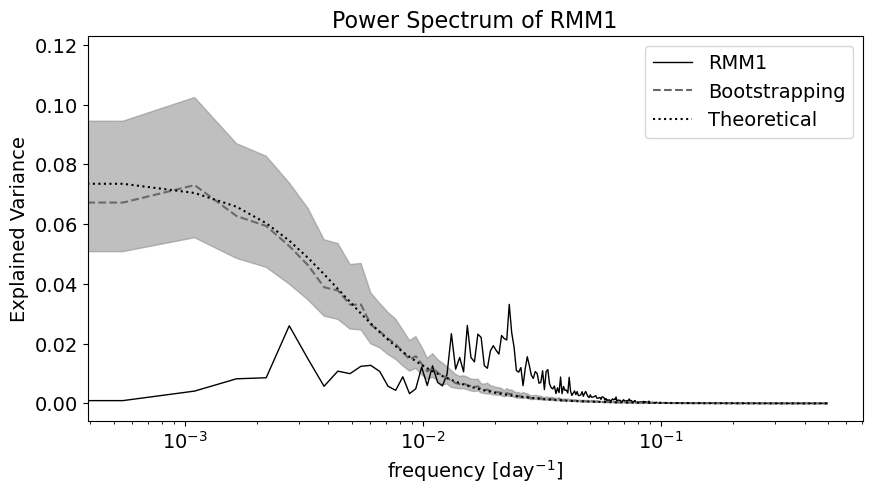

In [16]:
plt.figure(figsize = (10, 5))
plt.plot(freq_rmm1, sp_rmm1_list.mean(axis = 0), color = "k", linewidth = 1, label = "RMM1")
plt.plot(freq_red, sp_red_ens_mean, color = "dimgrey", linestyle = "--", label = "Bootstrapping")
plt.fill_between(freq_red, sp_conf_ens_low, sp_conf_ens_high, color = "grey", alpha = 0.5)
plt.plot(freq_theoretical, sp_theoretical, color = "k", linestyle = ":", label = "Theoretical")
plt.legend(fontsize = 14)
plt.xscale("log")
plt.xlabel("frequency [day$^{-1}$]", fontsize = 14)
plt.xticks(fontsize = 14)
plt.ylabel("Explained Variance", fontsize = 14)
plt.yticks(fontsize = 14)
plt.title("Power Spectrum of RMM1", fontsize = 16)

## References

Gilman, D. L., Fuglister, F. J., & Mitchell, J. M. (1963). On the power spectrum of “red noise”. Journal of the Atmospheric Sciences, 20(2), 182-184.